We start by loading in the Twitter dataset as described in the synopsis. 

In [78]:
import gc
import string
import re
import numpy as np
import pandas as pd
import nltk
nltk.download('words')
import gensim.downloader as api
import matplotlib.pyplot as plt

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\edmun\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


Load in the raw data

In [2]:
raw = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', on_bad_lines='skip', names='target,user_id,date,flag,user,text'.split(','))

Initial data exploration

In [3]:
raw.head()

,target,user_id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
raw['target'].value_counts()

0    800000
4    800000
Name: target, dtype: int64

Sample 20,000 rows from the original dataset

In [5]:
# stratified sampling
tweets = raw.groupby('target').apply(lambda x: x.sample(10000, random_state=42))

In [6]:
tweets = tweets.reset_index(drop=True)

In [7]:
tweets['target'].value_counts()

0    10000
4    10000
Name: target, dtype: int64

In [8]:
tweets.head()

,target,user_id,date,flag,user,text
0,0,1974671194,Sat May 30 13:36:31 PDT 2009,NO_QUERY,simba98,@xnausikaax oh no! where did u order from? tha...
1,0,1997882236,Mon Jun 01 17:37:11 PDT 2009,NO_QUERY,Seve76,A great hard training weekend is over. a coup...
2,0,2177756662,Mon Jun 15 06:39:05 PDT 2009,NO_QUERY,x__claireyy__x,"Right, off to work Only 5 hours to go until I..."
3,0,2216838047,Wed Jun 17 20:02:12 PDT 2009,NO_QUERY,Balasi,I am craving for japanese food
4,0,1880666283,Fri May 22 02:03:31 PDT 2009,NO_QUERY,djrickdawson,Jean Michel Jarre concert tomorrow gotta work...


Now, we write a function that cleans the data. I will detail what each line of code does to make it clear.

In [9]:
# apply this to each tweet
def clean_data(tweet):
    # removal of punctuations
    tweet = re.sub("[^-9A-Za-z ]", "" , tweet)
    # convert to lowercase
    tweet = "".join([i.lower() for i in tweet if i not in string.punctuation])
    # tokenize the words temporarily
    word_tokens = nltk.tokenize.word_tokenize(tweet)
    # removal of non-alphabetical words
    word_tokens = [w for w in word_tokens if w.isalpha()]
    # removal of non-english words like usernames
    words = set(nltk.corpus.words.words())
    word_tokens = [w for w in word_tokens if w in words]
    # removal of stop-words
    stop_words = nltk.corpus.stopwords.words('english')
    word_tokens = [w for w in word_tokens if not w in stop_words]
    # stemming
    stemmer = nltk.stem.PorterStemmer()
    word_tokens = [stemmer.stem(w) for w in word_tokens]
    # join back as string
    tweet = " ".join(word_tokens)
    return tweet

In [12]:
# compare the tweet before and after processing
print('Original:', tweets['text'][0])
print('Processed:', clean_data(tweets['text'][0]))

Original: @xnausikaax oh no! where did u order from? that's horrible 
Processed: oh u order that horribl


In [ ]:
tweets['cleaned_text'] = tweets['text'].apply(clean_data)
tweets = tweets.drop(columns=['text'])
tweets.head()

In [14]:
import gc
gc.collect()

2159

Save as a csv file

In [ ]:
tweets.to_csv('tweets.csv')

Now, we have the sampled dataset with pre-processed tweet text.

In [15]:
tweets = pd.read_csv('tweets.csv', index_col=0)

In [16]:
tweets = tweets.drop(columns=['user_id', 'date', 'flag', 'user'])

In [17]:
tweets.head()

,target,cleaned_text
0,0,oh u order that horribl
1,0,great hard train weekend coupl day rest lot co...
2,0,right work go free
3,0,crave food
4,0,jean concert tomorrow got ta work though


Remove any rows that have missing null values for cleaned text. 
This ensures that the pre-trained model has no issues processing the text.

In [18]:
tweets = tweets.dropna(axis=0)

In [21]:
tweets['target'] = tweets['target'].apply(lambda x: 1 if x==4 else 0)

Now, we obtain the phrasal embeddings for each cleaned tweet text in the tweets dataframe.
We use the GloVe Twitter 25 model, which contains pre-trained GloVe vectors based on 2 billion tweets, 27 billion tokens, and 1.2 million vocabulary.

Load in the pre-trained model

In [66]:
model = api.load('glove-twitter-25')

In [24]:
# takes in a tweet and outputs a list of word embeddings for each word
def get_embeddings(text):
    return np.array([model[w] for w in text.split() if model.__contains__(w)])

tweets['tokenized_text'] = tweets['cleaned_text'].apply(get_embeddings)
tweets.head()

,target,cleaned_text,tokenized_text
0,0,oh u order that horribl,"[[0.34172, -0.17305, 0.23311, 0.057375, -0.761..."
1,0,great hard train weekend coupl day rest lot co...,"[[-0.84229, 0.36512, -0.38841, -0.46118, 0.243..."
2,0,right work go free,"[[-0.43876, 0.095692, 0.0030075, -0.13195, -0...."
3,0,crave food,"[[-0.85832, 0.48558, -0.61313, 0.72877, -0.656..."
4,0,jean concert tomorrow got ta work though,"[[-0.70756, -1.2247, 0.087766, 0.27264, -0.412..."


In [52]:
sum([tweets['tokenized_text'][0][0], tweets['tokenized_text'][0][0]]) - tweets['tokenized_text'][0][0]*2



array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

Save as a csv file

In [25]:
tweets.to_csv('tweets.csv')

## Defining the Cluster Points and Centroids

In this section, we will define the cluster points and centroids in an OOP format. The requirements of each object class are as follows:

Class VectorSpace:

        Attributes:
        - Points: List(Points)
        - Centroids: List(Centroids)

        Methods:
        - Injest Points -> List(Points)
        - Inject Centroids -> List(Points)
        - Calculate Cosine Similarity between 2 Points -> Float
        - Assign Static Clusters -> Boolean
        - Assign Dynamic Clusters -> Boolean

Class Point:

        Attributes:
        - Vector Location: Array(Float)
        - Closest centroid: Point
        - Polarity: Int

        Methods:
        - Calculate Cosine Similarity with own centroid -> Float
        - Set centroid -> Boolean
        - Set polarity -> Boolean

Class Centroid(Point):

        Attributes:
        - Super.Point Attributes
        - Points assigned: List(Points)
        
        Methods:
        - Reset cluster: Boolean
        - Add Point to cluster: Boolean
        - Update vector location: Array(Float)

In [131]:
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import TSNE

In [74]:
class Point:
    def __init__(self, word, model):
        self.word = word
        self.vector = model[word] if model.__contains__(word) else None
        self.closest_centroid = None
        self.polarity = None

    def set_centroid(self, centroid):
        self.centroid = centroid
        return True

    def set_polarity(self, polarity):
        self.polarity = polarity
        return True

    def get_cosine_similarity_with_centroid(self):
        if self.closest_centroid is not None:
            return cosine_similarity(self.vector, self.closest_centroid.vector)
        else:
            raise Exception('Unable to calculate cosine similarity with NoneType: Centroid is undefined')

In [69]:
class Centroid(Point):
    def __init__(self, word, polarity, model):
        super.__init__(word, model)
        self.polarity = polarity
        self.cluster_points = []

    def reset_cluster(self):
        self.cluster_points = []
        return True

    def add_point_to_cluster(self, point):
        self.cluster_points.append(point)
        point.polarity = self.polarity
        point.closest_centroid = self
        return True

    def update_vector_location(self):
        cluster_mean = sum([point.vector for point in self.cluster_points])/len(self.cluster_points)
        self.vector = cluster_mean
        return True

In [192]:
class VectorSpace:
    def __init__(self):
        self.points = []
        self.centroids = []

    def inject_point(self, point):
        self.points.append(point)
        return True
    
    def inject_centroid(self, centroid):
        self.centroids.append(centroid)

    def calculate_cosine_similarity(self, point1, point2):
        return cosine_similarity(point1.vector, point2.vector)

    def assign_static_clusters(self):
        # To do
        # Implement static cluster algorithm
        return True

    def assign_dynamic_clusters(self):
        # To do 
        # Implement dynamic cluster algorithm
        return True

    def plot_points(self, n):
        words = []
        vectors = []
        for point in self.points:
            if point.word not in words:
                words.append(point.word)
                vectors.append(point.vector)

        words = np.asarray(words)[:n]
        vectors = np.array(vectors)[:n]
        
        tsne = TSNE(n_components=2)
        X_tsne = tsne.fit_transform(vectors)
        plt.figure(figsize=(20,20))
        plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
        for label, x, y in zip(words, X_tsne[:, 0], X_tsne[:, 1]):
            plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")
        plt.show()
                

#### Injecting Tweets into Vector Space

In this section, we will initialise a VectorSpace, and populate it with words from the Tweets. At the same time, we will maintain a hashtable to keep track of the corresponding point for each word that we can translate the points back to words in the form of the respective maximum similarity value.

In [193]:
tweets

,target,cleaned_text,tokenized_text
0,0,oh u order that horribl,"[[0.34172, -0.17305, 0.23311, 0.057375, -0.761..."
1,0,great hard train weekend coupl day rest lot co...,"[[-0.84229, 0.36512, -0.38841, -0.46118, 0.243..."
2,0,right work go free,"[[-0.43876, 0.095692, 0.0030075, -0.13195, -0...."
3,0,crave food,"[[-0.85832, 0.48558, -0.61313, 0.72877, -0.656..."
4,0,jean concert tomorrow got ta work though,"[[-0.70756, -1.2247, 0.087766, 0.27264, -0.412..."
...,...,...,...
19995,1,arm morn babi face boy guitar hero,"[[-0.34711, -0.66286, 0.24614, 0.39245, 0.6368..."
19996,1,sweet mother extend royal welcom,"[[-1.0864, -0.61674, 0.33613, 0.43232, -0.2094..."
19997,1,wouldnt mind watch derbi mint julep,"[[0.057749, 1.3264, -0.016871, -0.55858, -0.92..."
19998,1,shini nice like shini hate vista mean passion,"[[-1.2786, 0.37414, 0.24775, 0.20342, -0.01434..."


In [199]:
# Initialise points_look_up_table
points_lookup_table = dict()

# Initialise VectorSpace
vector_space = VectorSpace()

def tweet_to_vector_space(tweet, vector_space, model):
    for word in tweet.split():
        if model.__contains__(word):
            new_point = Point(word, model)
            vector_space.inject_point(new_point)
            points_lookup_table[word] = new_point
    return True
        

tweets['cleaned_text'].apply(lambda x: tweet_to_vector_space(x, vector_space=vector_space, model=model))


0        True
1        True
2        True
3        True
4        True
         ... 
19995    True
19996    True
19997    True
19998    True
19999    True
Name: cleaned_text, Length: 19479, dtype: bool

In [202]:
vector_space.points[0]

AttributeError: 'numpy.ndarray' object has no attribute 'equals'

c:\Users\edmun\Dropbox\NUS\Work\Y4S1\02807 - Computational Tools for Data Science\Project\02807-final-project\venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\edmun\Dropbox\NUS\Work\Y4S1\02807 - Computational Tools for Data Science\Project\02807-final-project\venv\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


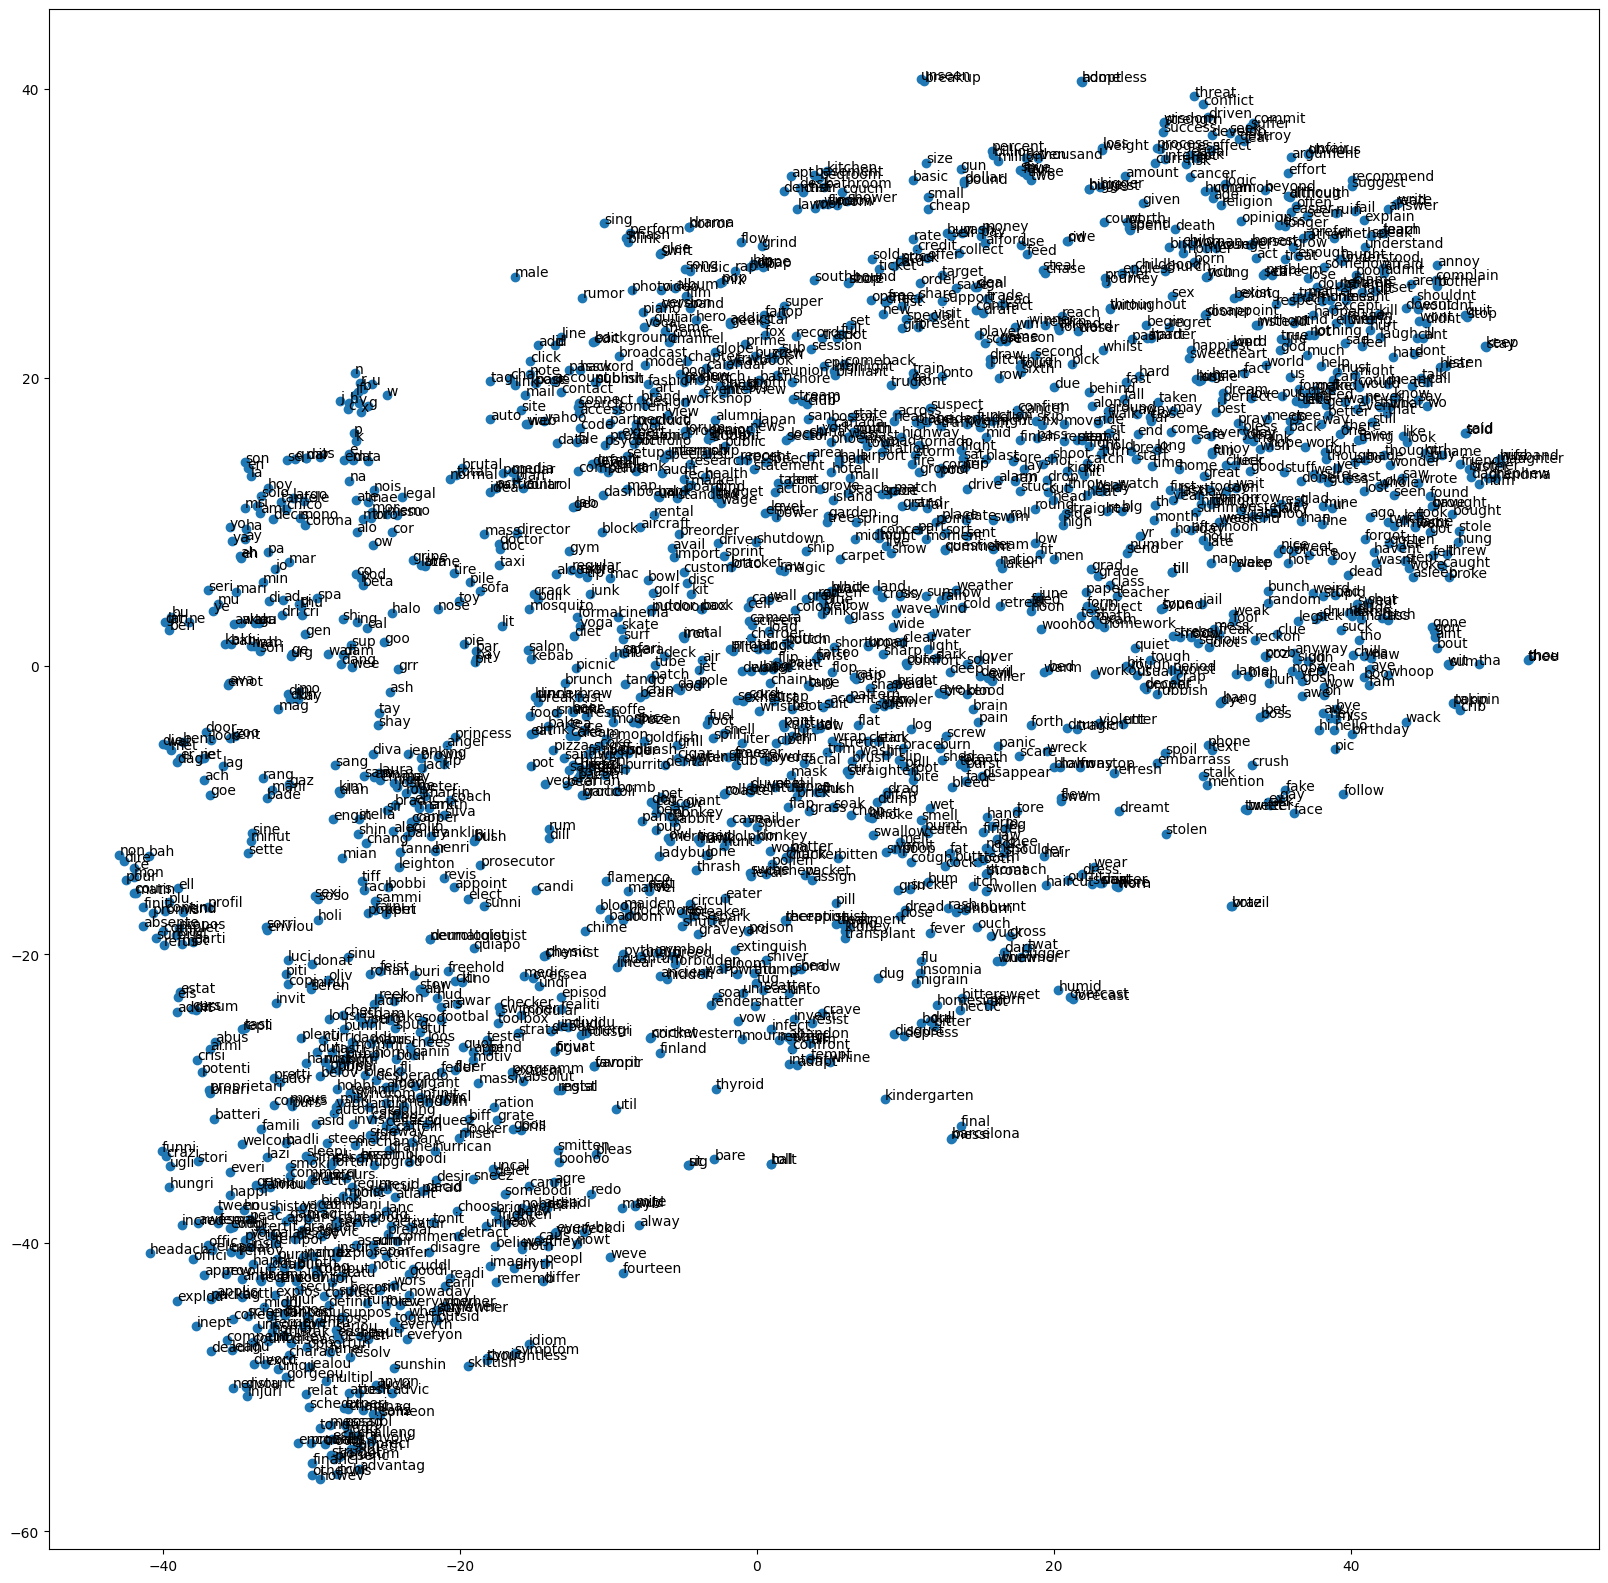

In [196]:
vector_space.plot_points(2000)